In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

### Create a data class to load the data into pytorch

In [8]:
class Data(Dataset):
    """
    Args:
        h5 file
    
    """
    def __init__(self,filename,transform=None, train=True):
        self.data=h5py.File(filename,'r')
                
        if train:
            self.x= torch.from_numpy(self.data['train_set_x'][...]).permute(0,3,1,2)
            self.y= torch.from_numpy(self.data['train_set_y'][...])
        else:
            self.x= torch.from_numpy(self.data['test_set_x'][...]).permute(0,3,1,2)
            self.y= torch.from_numpy(self.data['test_set_y'][...])
                
        self.transform=transform
        self.len=self.y.shape[0]        
    def __getitem__(self,index):
        sample={'image': self.x[index], 'label': self.y[index]}
        
        if self.transform:
            sample['image']=self.transform(sample['image'])
   
        return sample['image'],sample['label']

    def __len__(self):
        return self.len
        


### Create a cnn model

In [3]:

class ModelCNN(nn.Module):
    
    def __init__(self, in_features,out_features):
        super(ModelCNN,self).__init__()
        # first conv layer
        self.conv1= nn.Conv2d(in_channels=1,out_channels=in_features,kernel_size=5,padding=2)
        # relu1
        self.relu1=nn.ReLU()
        #maxpool1
        self.maxpool1=nn.MaxPool2d(kernel_size=8,stride=8,padding=0)
        # second conv layer
        self.conv2=nn.Conv2d(stride=1, in_channels=in_features,out_channels=out_features,kernel_size=5,padding=2)
        #relu2
        self.relu2=nn.ReLU()
        #maxpool 2
        self.maxpool2=nn.MaxPool2d(kernel_size=4,stride=4,padding=0)
        # fully connected layer
        self.fc=nn.Linear(out_features*2*2,6)
    
    def forward(self,x):
        # first conv layer
        out=self.conv1(x)
        # activation function
        out=self.relu1(out)
        # max pooling
        out=self.maxpool1(out)
        # first conv layer
        out=self.conv2(out)
        # activation function
        out=self.relu2(out)
        # max pooling
        out=self.maxpool2(out)
        # flatten the output
        out=out.view(out.size(0),-1)
         # fully connected layer
        out=self.fc(out)
        return out
    
    

In [25]:
model_cnn=ModelCNN(10,20)
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_cnn.parameters(),lr=0.001)

In [26]:
composed_transforms=transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.ToTensor()])
train_data_loader=DataLoader(Data("../hand_gestures_data/train_signs.h5",transform=composed_transforms),batch_size=100)
test_data_loader=DataLoader(Data("../hand_gestures_data/test_signs.h5",transform=composed_transforms, train=False),batch_size=100)

### Train the model and evaluate

In [1]:
LOSS=[]
accuracy_list=[]
N_test=test_data_loader.dataset.len
epochs=100
for epoch in range(epochs):
    for x,y in train_data_loader:
        optimizer.zero_grad()
        
        yhat= model_cnn(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
    correct=0
    #perform a prediction on the validation  data  
    for x_test, y_test in test_data_loader:

        z=model_cnn(x_test)
        _,yhat=torch.max(z.data,1)

        correct+=(yhat==y_test).sum().item()
        
   
    accuracy=correct/N_test

    accuracy_list.append(accuracy)
    LOSS.append(loss)
       

NameError: name 'test_data_loader' is not defined

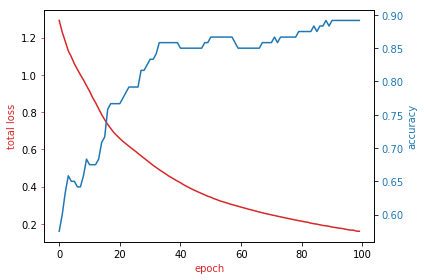

In [30]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()